In [1]:
# Cell 1 — imports & hyperparams
import os
import math
import random
from collections import deque, namedtuple

import numpy as np
import imageio
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

# DQN / env hyperparams
CODE_DIM = 128          # must match encoder code_dim
N_PREV = 5              # length of context used by decoder
K_CHOICES = [128, 96, 64, 32]   # actions = choose K (absolute #latent dims)
LAMBDA = 0.01           # penalty on K in reward
MAX_EPISODES = 300
MAX_STEPS_PER_EP = 400
BATCH_SIZE = 64
GAMMA = 0.99
LR_DQN = 1e-3
REPLAY_CAP = 10000
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 2000
TAU = 0.995   # soft update factor for target network


Device: cpu


In [2]:
# Cell 2 — load encoder/decoder classes and weights
from encoder import Encoder   # expects encoder.py present
from decoder import Decoder   # expects decoder.py present

# instantiate and load saved weights (from AE training)
encoder = Encoder(input_ch=1, code_dim=CODE_DIM).to(DEVICE)
decoder = Decoder(code_dim=CODE_DIM, n_prev=N_PREV, output_ch=1).to(DEVICE)

if os.path.exists("encoder.pth"):
    encoder.load_state_dict(torch.load("encoder.pth", map_location=DEVICE))
    print("Loaded encoder.pth")
else:
    print("Warning: encoder.pth not found. Run AE training first.")

if os.path.exists("decoder.pth"):
    decoder.load_state_dict(torch.load("decoder.pth", map_location=DEVICE))
    print("Loaded decoder.pth")
else:
    print("Warning: decoder.pth not found. Run AE training first.")

# freeze AE weights (we only train DQN)
encoder.eval(); decoder.eval()
for p in encoder.parameters(): p.requires_grad = False
for p in decoder.parameters(): p.requires_grad = False


In [3]:
# Cell 3 — LengthEnv: uses encoder & decoder, returns observation vector and reward
import gymnasium as gym
from PIL import Image

class LengthEnv(gym.Env):
    """
    Action: Discrete index selecting K from K_CHOICES.
    Observation: concatenation of cart state (4 dims) + first preview_dim elements of current z (float).
    Reward: PSNR between reconstructed (using truncated z and previous truncated z buffer) and original frame
            minus lambda * (K) penalty (we use K / CODE_DIM scaled or absolute depending on preference).
    """
    def __init__(self, encoder, decoder, device, preview_dim=16, lambda_penalty=LAMBDA, max_steps=400):
        super().__init__()
        self.device = device
        self.encoder = encoder.to(device)
        self.decoder = decoder.to(device)
        self.preview_dim = preview_dim
        self.lambda_penalty = lambda_penalty
        self.max_steps = max_steps
        self.length_levels = K_CHOICES
        self.action_space = gym.spaces.Discrete(len(self.length_levels))

        # CartPole observation ranges (approx)
        cart_low = np.array([-4.8, -np.finfo(np.float32).max, -0.418, -np.finfo(np.float32).max], dtype=np.float32)
        cart_high = -cart_low
        obs_low = np.concatenate([cart_low, np.full(self.preview_dim, -10.0)], axis=0)
        obs_high = np.concatenate([cart_high, np.full(self.preview_dim, 10.0)], axis=0)
        self.observation_space = gym.spaces.Box(low=obs_low, high=obs_high, dtype=np.float32)

        # underlying environment for frames and dynamics
        self.env = gym.make("CartPole-v1", render_mode="rgb_array")
        self.reset()

    def _preprocess(self, frame):
        # frame is RGB ndarray, convert to gray 64x64 normalized [0,1]
        img = Image.fromarray(np.asarray(frame)).convert("L").resize((64,64), Image.BILINEAR)
        arr = np.asarray(img, dtype=np.float32) / 255.0
        arr = arr[None, None, :, :]  # (1,1,H,W)
        return torch.tensor(arr, device=self.device)

    def reset(self, seed=None):
        res = self.env.reset(seed=seed)
        # gymnasium reset may return (obs, info) or obs only; handle both
        if isinstance(res, tuple) and len(res) >= 1:
            obs = res[0]
        else:
            obs = res
        self.cart_state = np.array(obs, dtype=np.float32)
        frame = self.env.render()
        self.frame = self._preprocess(frame)
        self.step_count = 0
        self.buffer = deque(maxlen=N_PREV)
        return self._get_obs(), {}

    def _get_obs(self):
        # encode current frame to latent and expose preview_dim of it
        with torch.no_grad():
            z = encoder(self.frame) if callable(encoder) else encoder(self.frame)
        preview = z[0, :self.preview_dim].cpu().numpy()
        return np.concatenate([self.cart_state, preview], axis=0).astype(np.float32)

    def step(self, action_idx):
        K = self.length_levels[int(action_idx)]
        # encode current frame
        with torch.no_grad():
            z = encoder(self.frame)  # shape (1, code_dim)
        z_limited = z.clone()
        if K < z.shape[1]:
            z_limited[:, K:] = 0.0

        # prepare prev_latents for decoder: if buffer less than N_PREV, use zeros
        if len(self.buffer) < N_PREV:
            prev = None
        else:
            prev = torch.cat(list(self.buffer), dim=0).unsqueeze(0).view(1, N_PREV, CODE_DIM).to(self.device)

        with torch.no_grad():
            rec = decoder.decode(z_limited, prev_latents=prev)  # (1,1,H,W)
        mse = F.mse_loss(rec, self.frame).item()
        psnr = 10.0 * math.log10(1.0 / (mse + 1e-8))
        # penalty is proportional to K (absolute) scaled — choose whichever is meaningful
        penalty = self.lambda_penalty * (K / float(CODE_DIM))
        reward = psnr - penalty

        # step the underlying env with a simple balancing policy for continuity (or random)
        # here we use a simple heuristic controller for the cart to avoid quick terminations
        action_env = 1 if self.cart_state[2] > 0 else 0
        step_res = self.env.step(action_env)
        # gymnasium step returns (obs, reward, terminated, truncated, info); handle variants
        if len(step_res) == 5:
            obs, _, terminated, truncated, info = step_res
        else:
            # legacy gym: obs, reward, done, info
            obs, _, done, info = step_res
            terminated = done; truncated = False

        self.cart_state = np.array(obs, dtype=np.float32)
        self.frame = self._preprocess(self.env.render())
        self.step_count += 1
        done = terminated or truncated or (self.step_count >= self.max_steps)
        return self._get_obs(), float(reward), bool(done), False, {}

    def close(self):
        self.env.close()


In [4]:
# Cell 4 — DQN code + replay memory
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)
    def push(self, *args):
        self.memory.append(Transition(*args))
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    def __len__(self):
        return len(self.memory)

class DQN(nn.Module):
    def __init__(self, n_obs, n_actions):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_obs, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, n_actions)
        )
    def forward(self, x):
        return self.net(x)

# instantiate environment
env = LengthEnv(encoder, decoder, DEVICE, preview_dim=16, lambda_penalty=LAMBDA, max_steps=MAX_STEPS_PER_EP)
n_actions = env.action_space.n
n_obs = env.observation_space.shape[0]
print("Env observation dim:", n_obs, "n_actions:", n_actions)

policy_net = DQN(n_obs, n_actions).to(DEVICE)
target_net = DQN(n_obs, n_actions).to(DEVICE)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.Adam(policy_net.parameters(), lr=LR_DQN)
memory = ReplayMemory(REPLAY_CAP)

steps_done = 0
def select_action(state):
    global steps_done
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if random.random() > eps_threshold:
        with torch.no_grad():
            s = torch.tensor(state, dtype=torch.float32, device=DEVICE).unsqueeze(0)
            return int(policy_net(s).argmax(dim=1).item())
    else:
        return random.randrange(n_actions)


C:\Users\Victoriya\AppData\Roaming\Python\Python312\site-packages\gymnasium\spaces\box.py:236: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
C:\Users\Victoriya\AppData\Roaming\Python\Python312\site-packages\gymnasium\spaces\box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


✅ Initialized fc_enc with input size 4096
Env observation dim: 20 n_actions: 4


In [5]:
# Cell 5 — optimization helper and training loop
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    state_batch = torch.tensor(np.stack(batch.state), dtype=torch.float32, device=DEVICE)
    action_batch = torch.tensor(batch.action, dtype=torch.int64, device=DEVICE).unsqueeze(1)
    reward_batch = torch.tensor(batch.reward, dtype=torch.float32, device=DEVICE).unsqueeze(1)

    non_final_mask = torch.tensor([s is not None for s in batch.next_state], device=DEVICE, dtype=torch.bool)
    non_final_next = torch.tensor([s for s in batch.next_state if s is not None], dtype=torch.float32, device=DEVICE) if any(non_final_mask) else None

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, 1, device=DEVICE)
    with torch.no_grad():
        if non_final_next is not None:
            next_state_values[non_final_mask] = target_net(non_final_next).max(1)[0].unsqueeze(1)

    expected_values = reward_batch + GAMMA * next_state_values

    loss = nn.SmoothL1Loss()(state_action_values, expected_values.detach())
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(policy_net.parameters(), 5.0)
    optimizer.step()

# Training loop
episode_rewards = []
for ep in range(1, MAX_EPISODES + 1):
    obs, _ = env.reset()
    total_reward = 0.0
    for t in range(MAX_STEPS_PER_EP):
        action = select_action(obs)
        next_obs, reward, done, _, _ = env.step(action)
        memory.push(obs, action, None if done else next_obs, reward)
        obs = next_obs
        total_reward += reward

        optimize_model()

        # soft update target
        for tp, pp in zip(target_net.parameters(), policy_net.parameters()):
            tp.data.copy_(TAU * pp.data + (1.0 - TAU) * tp.data)

        if done:
            break
    episode_rewards.append(total_reward)
    if ep % 10 == 0:
        avg_last = np.mean(episode_rewards[-50:]) if len(episode_rewards) >= 1 else total_reward
        print(f"Episode {ep}/{MAX_EPISODES} | Reward: {total_reward:.2f} | avg50: {avg_last:.2f}")

print("DQN training complete.")
# save policy net
torch.save(policy_net.state_dict(), "dqn_policy.pth")


C:\Users\Victoriya\AppData\Local\Temp\ipykernel_11040\2838671163.py:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:256.)
  non_final_next = torch.tensor([s for s in batch.next_state if s is not None], dtype=torch.float32, device=DEVICE) if any(non_final_mask) else None


Episode 10/300 | Reward: 262.31 | avg50: 280.97
Episode 20/300 | Reward: 262.34 | avg50: 287.53
Episode 30/300 | Reward: 241.61 | avg50: 279.59
Episode 40/300 | Reward: 269.20 | avg50: 272.86
Episode 50/300 | Reward: 345.21 | avg50: 283.04
Episode 60/300 | Reward: 358.92 | avg50: 288.71
Episode 70/300 | Reward: 372.78 | avg50: 286.08
Episode 80/300 | Reward: 324.42 | avg50: 289.11
Episode 90/300 | Reward: 338.22 | avg50: 294.35
Episode 100/300 | Reward: 379.73 | avg50: 286.49
Episode 110/300 | Reward: 310.69 | avg50: 277.09
Episode 120/300 | Reward: 331.39 | avg50: 282.48
Episode 130/300 | Reward: 269.30 | avg50: 281.25
Episode 140/300 | Reward: 407.25 | avg50: 284.29
Episode 150/300 | Reward: 358.98 | avg50: 286.77
Episode 160/300 | Reward: 379.65 | avg50: 293.81
Episode 170/300 | Reward: 179.52 | avg50: 288.01
Episode 180/300 | Reward: 296.90 | avg50: 291.03
Episode 190/300 | Reward: 220.95 | avg50: 286.89
Episode 200/300 | Reward: 296.87 | avg50: 284.96
Episode 210/300 | Reward: 172

Total saved frames: 35
FFMPEG write failed: TiffWriter.write() got an unexpected keyword argument 'fps'
Saved dqn_reconstructed.gif (fallback).


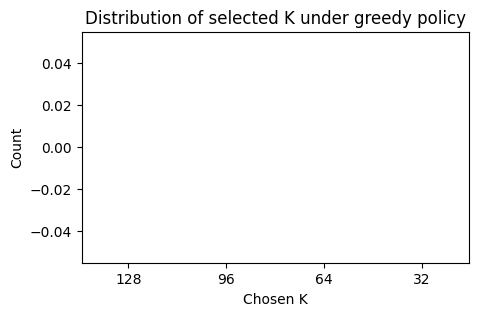

In [7]:
# Cell 6 — evaluate greedy policy and save reconstructed video (fixed)
import imageio
import numpy as np
from IPython.display import HTML, display

policy_net.eval()
obs, _ = env.reset()
frames_out = []
chosen_Ks = []
with torch.no_grad():
    for t in range(1000):   # generate up to 1000 frames or until done
        s = torch.tensor(obs, dtype=torch.float32, device=DEVICE).unsqueeze(0)
        act = int(policy_net(s).argmax(dim=1).item())  # greedy
        chosen_Ks.append(K_CHOICES[act])

        # step environment (this updates env.frame and env.buffer)
        next_obs, reward, done, _, _ = env.step(act)

        # reconstruct current frame using AE (same as env did)
        with torch.no_grad():
            z = encoder(env.frame)                     # (1, CODE_DIM)
            K = K_CHOICES[act]
            z_l = z.clone()
            if K < z.shape[1]:
                z_l[:, K:] = 0.0
            prev = None if len(env.buffer) < N_PREV else torch.cat(list(env.buffer), dim=0).unsqueeze(0).view(1, N_PREV, CODE_DIM)
            rec = decoder.decode(z_l, prev_latents=prev)  # (1,1,H,W)
            frame_np = (rec.cpu().numpy()[0,0] * 255).astype(np.uint8)  # (H,W) uint8
            # convert gray->RGB for ffmpeg-compatible frames
            frame_rgb = np.stack([frame_np, frame_np, frame_np], axis=2)  # (H,W,3)
            frames_out.append(frame_rgb)

        obs = next_obs
        if done:
            break

print("Total saved frames:", len(frames_out))

# --- ensure ffmpeg plugin is available; try to save with imageio-ffmpeg backend
try:
    imageio.get_writer("dqn_reconstructed.mp4", fps=30, codec='libx264').append_data  # quick check
    with imageio.get_writer("dqn_reconstructed.mp4", fps=30, codec='libx264') as writer:
        for fr in frames_out:
            writer.append_data(fr)
    print("Saved dqn_reconstructed.mp4, frames:", len(frames_out))
except Exception as e:
    print("FFMPEG write failed:", e)
    # fallback: save as GIF (slower & larger) — useful for debugging
    try:
        gif_frames = [(fr[...,0]).astype(np.uint8) for fr in frames_out]  # grayscale frames
        imageio.mimsave("dqn_reconstructed.gif", gif_frames, fps=10)
        print("Saved dqn_reconstructed.gif (fallback).")
    except Exception as e2:
        print("Fallback GIF also failed:", e2)

# display video in notebook (works in Colab/Jupyter)
if os.path.exists("dqn_reconstructed.mp4"):
    display(HTML(f"""<video width=320 controls>
                     <source src="dqn_reconstructed.mp4" type="video/mp4">
                     Your browser does not support the video tag.
                   </video>"""))
elif os.path.exists("dqn_reconstructed.gif"):
    display(HTML(f'<img src="dqn_reconstructed.gif" />'))

# show histogram of chosen K
import matplotlib.pyplot as plt
plt.figure(figsize=(5,3))
plt.hist(chosen_Ks, bins=np.arange(len(K_CHOICES)+1)-0.5, rwidth=0.6)
plt.xticks(range(len(K_CHOICES)), K_CHOICES)
plt.xlabel("Chosen K")
plt.ylabel("Count")
plt.title("Distribution of selected K under greedy policy")
plt.show()
